## Importing Libraries

In [2]:
import os
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [3]:
# File Directory for both the train and test
train_path = "Data - All Trying/train_preprocessed"
val_path = "Data - All Trying/valid_preprocessed"
test_path = "Data - All Trying/test"

## Importing Keras for Image Classification

In [4]:
import tensorflow.keras
from tensorflow.keras import layers
from tensorflow.keras import Model 
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Dense,Conv2D, Flatten, MaxPool2D, Dropout

In [5]:
batchsize = 20

In [6]:
train_datagen = ImageDataGenerator(rescale = 1.0/255.0,
                                  horizontal_flip = True,
                                  fill_mode = 'nearest',
                                  zoom_range=0.2,
                                  shear_range = 0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  rotation_range=0.4)

train_data = train_datagen.flow_from_directory(train_path,
                                                   batch_size = batchsize,
                                                   target_size = (350,350),
                                                   class_mode = 'categorical')

Found 1935 images belonging to 4 classes.


In [7]:
train_data.class_indices

{'adenocarcinoma': 0,
 'large.cell.carcinoma': 1,
 'normal': 2,
 'squamous.cell.carcinoma': 3}

In [8]:
val_datagen = ImageDataGenerator(rescale = 1.0/255.0)
val_data = val_datagen.flow_from_directory(val_path,
                                                   batch_size = batchsize,
                                                   target_size = (350,350),
                                                   class_mode = 'categorical')

Found 216 images belonging to 4 classes.


In [9]:
val_data.class_indices

{'adenocarcinoma': 0,
 'large.cell.carcinoma': 1,
 'normal': 2,
 'squamous.cell.carcinoma': 3}

In [10]:
test_datagen = ImageDataGenerator(rescale = 1.0/255.0)
test_data = test_datagen.flow_from_directory(test_path,
                                                   batch_size = batchsize,
                                                   target_size = (350,350),
                                                   class_mode = 'categorical')

Found 219 images belonging to 4 classes.


In [11]:
test_data.class_indices

{'adenocarcinoma': 0,
 'large.cell.carcinoma': 1,
 'normal': 2,
 'squamous.cell.carcinoma': 3}

## Inceptionv3 Model

In [58]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

base_model = InceptionV3(input_shape = (350, 350, 3), 
                         include_top = False, 
                         weights = 'imagenet')

In [59]:
    for layer in base_model.layers:
        layer.trainable = False

In [60]:
x = layers.Flatten()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)

# Add a final sigmoid layer with 4 node for classification output
x = layers.Dense(4, activation='sigmoid')(x)

model_incep = tf.keras.models.Model(base_model.input, x)

model_incep.compile(optimizer = tensorflow.keras.optimizers.RMSprop(learning_rate=0.0001), 
                    loss = 'categorical_crossentropy', 
                    metrics = ['accuracy'])

In [16]:
# Adding Model check point Callback

mc = ModelCheckpoint(
    filepath="./ct_incep_best_model_final.hdf5",
    monitor= 'val_accuracy', 
    verbose= 1,
    save_best_only= True, 
    mode = 'auto'
    );

call_back = [mc];

In [17]:
# Fitting the Model
incep = model_incep.fit(
    train_data, 
    steps_per_epoch = train_data.samples//train_data.batch_size, 
    epochs = 50, 
    validation_data = val_data, 
    validation_steps = val_data.samples//val_data.batch_size,
    callbacks = call_back 
    )

#32 original epochs

Epoch 1/50
96/96 [==============================] - ETA: 0s - loss: 5.9271 - accuracy: 0.4355
Epoch 1: val_accuracy improved from -inf to 0.39500, saving model to .\ct_incep_best_model_final.hdf5
96/96 [==============================] - 506s 5s/step - loss: 5.9271 - accuracy: 0.4355 - val_loss: 2.4927 - val_accuracy: 0.3950
Epoch 2/50
96/96 [==============================] - ETA: 0s - loss: 1.2052 - accuracy: 0.5666
Epoch 2: val_accuracy improved from 0.39500 to 0.59500, saving model to .\ct_incep_best_model_final.hdf5
96/96 [==============================] - 498s 5s/step - loss: 1.2052 - accuracy: 0.5666 - val_loss: 0.8471 - val_accuracy: 0.5950
Epoch 3/50
96/96 [==============================] - ETA: 0s - loss: 0.9786 - accuracy: 0.5979
Epoch 3: val_accuracy did not improve from 0.59500
96/96 [==============================] - 495s 5s/step - loss: 0.9786 - accuracy: 0.5979 - val_loss: 1.3622 - val_accuracy: 0.4900
Epoch 4/50
96/96 [==============================] - ETA: 0s - loss: 0.

In [61]:
# Loading the Best Fit Model 
model = load_model("./ct_incep_best_model_final.hdf5")

In [19]:
# Checking the Accuracy of the Model 
accuracy_incep = model.evaluate_generator(generator= test_data)[1] 
print(f"The accuracy of the model is = {accuracy_incep*100} %")

The accuracy of the model is = 89.04109597206116 %


In [20]:
incep.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

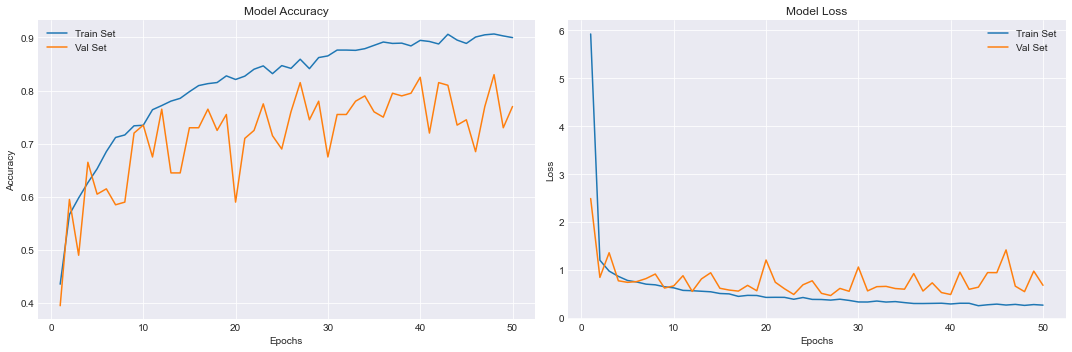

In [25]:
plt.style.use('seaborn-darkgrid')

# Plot model performance
acc = incep.history['accuracy']
val_acc = incep.history['val_accuracy']
loss = incep.history['loss']
val_loss = incep.history['val_loss']
epochs_range = range(1, len(incep.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.savefig("IV3 results")
plt.show()

## Comparison

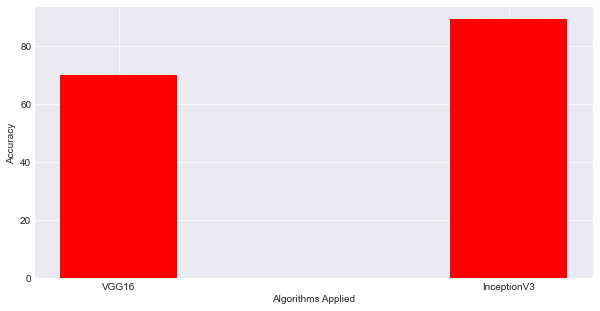

In [26]:
plt.style.use('seaborn-darkgrid')

accuracy_vgg = 0.7079365253448486
algos = ['VGG16', 'InceptionV3']
accuracy = [accuracy_vgg, accuracy_incep]
accuracy = np.floor([i * 100 for i in accuracy])
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(algos, accuracy, color ='red', width = 0.3)
 
plt.xlabel("Algorithms Applied")
plt.ylabel("Accuracy")
plt.savefig("Comparision resuls")
plt.show()

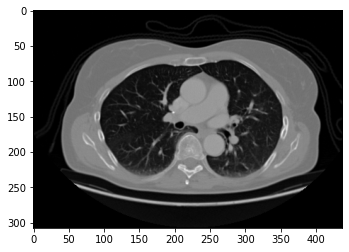

In [24]:
image = img.imread("Data - All Trying/test/large.cell.carcinoma/000110.png")
plt.imshow(image)
plt.show()

In [12]:
# Loading the Best Fit Model 
model = load_model("./ct_incep_best_model_final.hdf5")

### Predictions

In [13]:
from matplotlib import image as imaging

In [14]:
def chestScanPrediction(path, _model):
    i = imaging.imread(path)
    plt.imshow(i)
    plt.show()
    classes_dir = ["Adenocarcinoma","Large cell carcinoma","Normal","Squamous cell carcinoma"]
    img = image.load_img(path, target_size=(350,350))
    norm_img = image.img_to_array(img)/255
    input_arr_img = np.array([norm_img])
    pred = np.argmax(_model.predict(input_arr_img))
    print(classes_dir[pred])

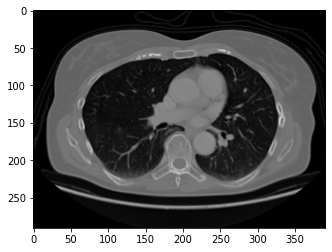

1/1 [==============================] - 2s 2s/step
Large cell carcinoma


In [15]:
path = "Data - All Trying/test/large.cell.carcinoma/000126.png"
chestScanPrediction(path,model)

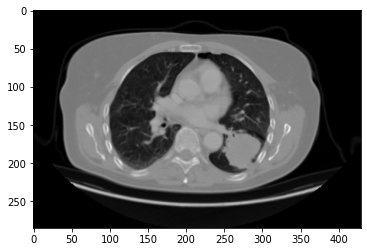

1/1 [==============================] - 0s 236ms/step
Adenocarcinoma


In [16]:
path = "Data - All Trying/test/adenocarcinoma/000134.png"
chestScanPrediction(path,model)

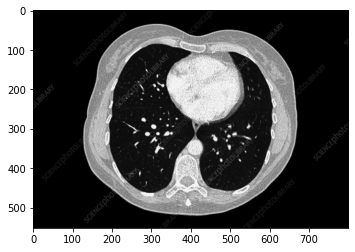

1/1 [==============================] - 0s 244ms/step
Normal


In [17]:
path = "Data - All Trying/test/normal/6.png"
chestScanPrediction(path,model)

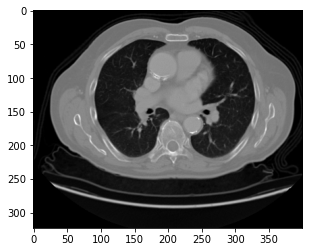

1/1 [==============================] - 0s 227ms/step
Squamous cell carcinoma


In [18]:
path = "Data - All Trying/test/squamous.cell.carcinoma/000124.png"
chestScanPrediction(path,model)